In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST

In [9]:
mnist = MNIST(root='.', download=True)
images = np.stack([data[0] for data in mnist]).astype(np.float32)
images = images / 128 - 1    # normalize between -1 and 1

A sample of the data that the model will be trained on. This model is unsupervised meaning there is no human labelling required.

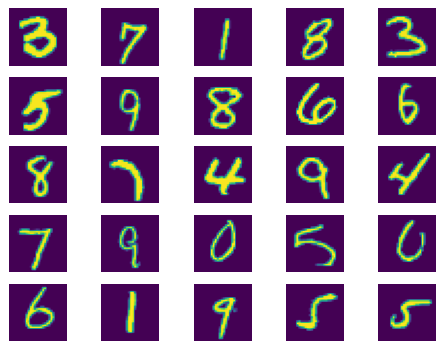

In [5]:
plt.figure(dpi=90)
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(images[np.random.choice(len(images))])
    plt.axis('off')
plt.show()

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.discriminator = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Flatten(),
            nn.Linear(128*7*7, 1),
            nn.Sigmoid()
        )
        

    def forward(self, x):
        return self.discriminator(x)

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.generator = nn.Sequential(
            nn.ConvTranspose2d(100, 256, kernel_size=7, stride=1, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 1, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.generator(x)

gen = Generator()
disc = Discriminator()
if torch.cuda.is_available():
    gen = gen.cuda()
    disc = disc.cuda()

In [7]:
def generate_samples(model, num_samples):
    random_dimension = 100
    noise = torch.randn(num_samples, random_dimension, 1, 1)
    return(model(noise))

The model works by generating random noise as input. The model then learns a unique mapping space that will convert these inuputs into desired output.

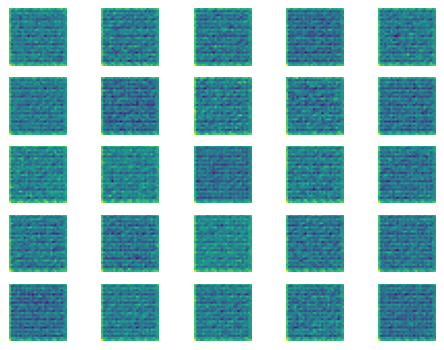

In [8]:
gen.eval()
samples = generate_samples(gen, 25).detach().cpu().squeeze().numpy()
plt.figure(dpi=90)
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(samples[i])
    plt.axis('off')
plt.show()

In [25]:
def train_gan(gen, disc, images, num_epochs, batch_size):
    from tqdm.autonotebook import tqdm
    from torch.utils.data import DataLoader

    counter = 0
    
    losses_gen = []
    losses_disc = []

    gen.train()
    disc.train()
    loader = DataLoader(images, batch_size=batch_size, shuffle=True)

    optimizer_gen = torch.optim.Adam(gen.parameters(), lr=0.002, betas=(0.5, 0.999))
    optimizer_disc = torch.optim.Adam(disc.parameters(), lr=0.002, betas=(0.5, 0.999))

    pbar = tqdm(range(num_epochs))
    for e in pbar:
        for i, data_real in enumerate(loader):
            if torch.cuda.is_available():
                data_real = data_real.cuda()

            disc.train()
            disc.requires_grad_(True)

            b = batch_size
            
            if counter % 1 == 0:
            
                fakes = generate_samples(gen, b).detach().clone()
            
                real_images = data_real.unsqueeze(1)
                inputs_disc = torch.cat([fakes, real_images])
            
                fake_label = torch.zeros(b, 1)
                real_label = torch.ones(b, 1)

                labels_disc = torch.cat([fake_label, real_label])
            
                if torch.cuda.is_available():
                    inputs_disc = inputs_disc.cuda()
                    labels_disc = labels_disc.cuda()
       
                pred = disc(inputs_disc)
                
                loss_disc = nn.BCELoss()(pred, labels_disc)
            
                optimizer_disc.zero_grad()
                loss_disc.backward()
                optimizer_disc.step()
            
                losses_disc.append(loss_disc.item())
                
            else:
                losses_disc.append(loss_disc.item())

            disc.eval()
            disc.requires_grad_(False)

            inputs_gen = generate_samples(gen, b)
            labels_gen = torch.ones(b, 1)
            
            if torch.cuda.is_available():
                inputs_gen = inputs_gen.cuda()
                labels_gen = labels_gen.cuda()

            
            loss_gen = nn.BCELoss()(disc(inputs_gen), labels_gen)
                        
            optimizer_gen.zero_grad()
            loss_gen.backward()
            optimizer_gen.step()
            
            losses_gen.append(loss_gen.item())
            
            
            counter = counter + 1
            
    ####################################################################################

            pbar.set_postfix(loss_gen=losses_gen[-1], loss_disc=losses_disc[-1])
    return losses_gen, losses_disc

In [64]:
num_epochs = 3
batch_size = 60

losses_gen, losses_disc = train_gan(gen, disc, images, num_epochs=num_epochs, batch_size=batch_size)

  0%|          | 0/3 [00:00<?, ?it/s]

A GAN model's characteristic feature is the adversarial training of a generator and a discrimator, where both loss functions are trained against each other. In this case we want both loss functions to stabilize.

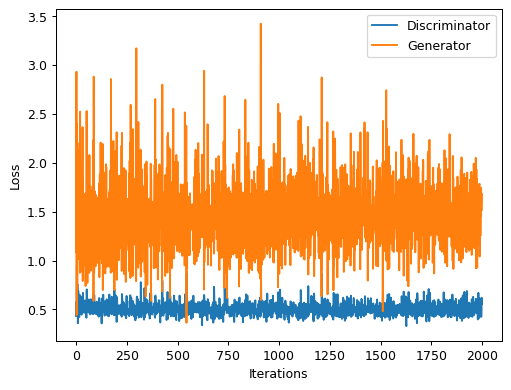

In [18]:
plt.figure(dpi=90)
plt.plot(losses_disc, label='Discriminator')
plt.plot(losses_gen, label='Generator')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

A sample output from about 2 hours of training. With each training increments that shapes begin to resemble handwritten digits with more certaintly. This model was trained on digits, with greater computing power it can be applied to any image set.

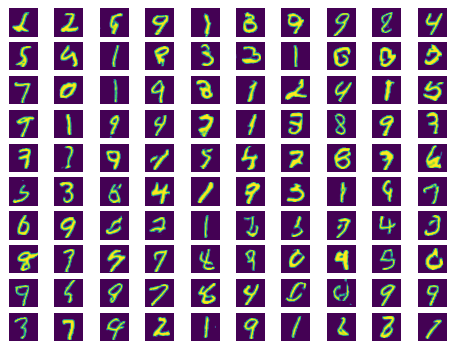

In [69]:
gen.eval()
samples = generate_samples(gen, 100).detach().cpu().squeeze().numpy()
plt.figure(dpi=90)
for i in range(100):
    plt.subplot(10, 10, i+1)
    plt.imshow(samples[i])
    plt.axis('off')
plt.show()